## EDA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import re
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS  
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans

import datetime as dt
#import pandas_datareader.data as web

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
df = pd.read_csv("data/apple-twitter-sentiment-texts.csv")

df.head()

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [3]:
df.shape

(1630, 2)

In [4]:
# dropping ALL duplicate values but keep the first occur

df.drop_duplicates(subset ="text", inplace = True)  # keep = False,
df.reset_index(drop = True, inplace= True)
df.tail()

,text,sentiment
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1
1620,Finally got my iPhone 6 in the mail and it com...,-1
1621,@umo_games @Apple ended up getting a new compu...,0
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,0
1623,The iPhone 6 May Have A Longer Upgrade Cycle -...,-1


In [5]:
df.shape 

(1624, 2)

Only 6 cut down to 1624

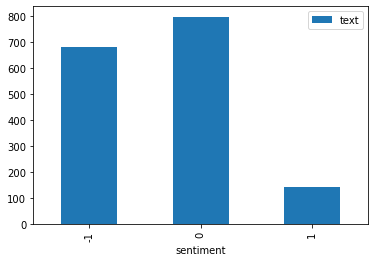

In [6]:
df.groupby('sentiment').count().plot(kind='bar')
plt.savefig('charts/sentiment', bbox_inches='tight')

## Text Processing

In [7]:

# preprocessing  

def remove_pattern(df):
    """This function removes the user handle, URL, emojicons"""
    
    df['tidy_tweet'] = df['text'].str.replace(r'@[\w]*', '')
    df['tidy_tweet'] = df['tidy_tweet'].str.replace(r'https?:\/\/.*[\r\n]*', '')    # remove URL
    df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")  # remove digits
   # df['tidy_tweet'] = " ".join(df['tidy_tweet'].str.split())  # using split() + join()  # remove additional space from string 
    
    
    return df

In [8]:
remove_pattern(df)


,text,sentiment,tidy_tweet
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1,Wow Yall needa step it up RT Music and sna...
1,What Happened To Apple Inc? http://t.co/FJEX...,0,What Happened To Apple Inc
2,Thank u @apple I can now compile all of the pi...,1,Thank u I can now compile all of the pics tha...
3,The oddly uplifting story of the Apple co-foun...,0,The oddly uplifting story of the Apple co foun...
4,@apple can i exchange my iphone for a differen...,0,can i exchange my iphone for a different colo...
...,...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1,Those PICK UP THE SLACK YOU FUCK BOYS
1620,Finally got my iPhone 6 in the mail and it com...,-1,Finally got my iPhone in the mail and it com...
1621,@umo_games @Apple ended up getting a new compu...,0,ended up getting a new computer anyhow work...
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,0,The Year Old #WizKid Who Turned Down Has N...


In [9]:
df['text'][1]

'What Happened To Apple Inc?   http://t.co/FJEXI3oP0U  #aapl #apple @MoneyPress http://t.co/wXKmmTMArW'

In [10]:
df['tidy_tweet'][1]

'What Happened To Apple Inc    '

In [11]:
# if didnt do 3 stem and tokenize -> can use this -> using split() + join() # remove additional space from string 

res = " ".join(df['tidy_tweet'][1].split())
res

#  df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

'What Happened To Apple Inc'

## Stem and tokenize

In [12]:
from nltk.stem.porter import *

def tokenize_and_stem(df):
    """This function tokenizes the tweets and stems them and then
    joins them back together."""
    tokenized_tweet = df['tidy_tweet'].astype(str).str.split()  # apply(lambda x: x.split()) #.lower().split(' ')
    stemmer = PorterStemmer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    df['tidy_tweet'] = tokenized_tweet
    return df

In [13]:
tokenize_and_stem(df)


,text,sentiment,tidy_tweet
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1,wow yall needa step it up RT music and snapcha...
1,What Happened To Apple Inc? http://t.co/FJEX...,0,what happen To appl inc
2,Thank u @apple I can now compile all of the pi...,1,thank u I can now compil all of the pic that i...
3,The oddly uplifting story of the Apple co-foun...,0,the oddli uplift stori of the appl co founder ...
4,@apple can i exchange my iphone for a differen...,0,can i exchang my iphon for a differ color lmao...
...,...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1,those pick UP the slack you fuck boy
1620,Finally got my iPhone 6 in the mail and it com...,-1,final got my iphon in the mail and it come out...
1621,@umo_games @Apple ended up getting a new compu...,0,end up get a new comput anyhow work comput her...
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,0,the year old #wizkid who turn down ha nab back...


In [14]:
df['tidy_tweet'][0]  

'wow yall needa step it up RT music and snapchat at the same damn time thank you #note'

In [15]:
nltk.download('stopwords')
         
# add 'TSLA' into stopwords  
                                                                    # this
stop_words = ENGLISH_STOP_WORDS.union(['aapl']) 


#ENGLISH_STOP_WORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoduque/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
corpus = df['tidy_tweet'].fillna(value='')  # taking care Nan

In [17]:
for tweet in df['text'].sample(10).values:
    print(tweet)
    print()

@OneRepublic @Apple Ooh my god

13% left what even is this shit @apple

@OneRepublic @Apple So amazing

@whereiscooldude @Apple I kind of thought that before hand

10 best #SteveJobs #apple #aapl #tech30 http://t.co/FkrkG1iF7g via

@apple your chargers suck ass! They just love to break!

#AAPL:After-hours buzz: Apple, Bob Evans Farms &amp; more...http://t.co/PHVzSFanso

You pieces of shit @apple! 
God damnit man!

@apple #apple corporate raiders selling weak products that stop working within weeks&amp;apple gets out of warranty by claiming dampness

@apple @nike #BlackDollarsMatter: An Open Letter to the Companies That Support #LGBTQ Marriage Equality/Civil Rights. http://t.co/F2uslRVbBc



In [18]:
tfidf = TfidfVectorizer(stop_words=stop_words)  # (stop_words='english') 

tweet_word_matrix = tfidf.fit_transform(corpus)

vocab = tfidf.get_feature_names()
vocab


['aaron',
 'abandon',
 'abck',
 'abe',
 'abil',
 'abl',
 'ableton',
 'abrick',
 'absolut',
 'abus',
 'accent',
 'accept',
 'access',
 'accessori',
 'accid',
 'accident',
 'accord',
 'accus',
 'achil',
 'acid',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'ad',
 'adapt',
 'add',
 'addi',
 'addit',
 'address',
 'adjust',
 'admir',
 'admit',
 'adopt',
 'advanc',
 'advertis',
 'af',
 'africa',
 'agai',
 'age',
 'ago',
 'agre',
 'agreement',
 'ahahahah',
 'ahead',
 'ahhhhhhh',
 'aid',
 'ain',
 'aint',
 'air',
 'airdrop',
 'airmil',
 'airmilesshop',
 'airplay',
 'airport',
 'aka',
 'alabama',
 'alarm',
 'album',
 'alex',
 'alibaba',
 'align',
 'alleg',
 'allow',
 'alon',
 'alreadi',
 'alt',
 'altern',
 'alway',
 'amaz',
 'amazingli',
 'amazon',
 'amend',
 'america',
 'amid',
 'amnt',
 'amp',
 'amzn',
 'anal',
 'analysi',
 'analyst',
 'anderson',
 'android',
 'androidauto',
 'anf',
 'anger',
 'angri',
 'ani',
 'anna',
 'announc',
 'annoy',
 'anon',
 'anoth',
 'answer',
 'anti',
 'antitr

# Topic Modeling - NMF

In [19]:
nmf = NMF(n_components=2)   #15 --> 10 --> 5 --> 3 --> 2

nmf.fit(tweet_word_matrix)  # tweet_word_matrix = tfidf.fit_transform(corpus)

NMF(n_components=2)

In [20]:
tweet_topic_matrix = nmf.transform(tweet_word_matrix)


In [21]:
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix).add_prefix('topic_')

#tweet_topic_matrix_df[['text', 'tidy_tweet']] = df[['text', 'tidy_tweet']]
tweet_topic_matrix_df

,topic_0,topic_1
0,0.012275,0.043671
1,0.000000,0.135332
2,0.000945,0.013107
3,0.000000,0.044529
4,0.000000,0.052419
...,...,...
1619,0.108777,0.000000
1620,0.000000,0.072270
1621,0.001103,0.033004
1622,0.000732,0.013304


In [22]:
tweets_df = df[['text', 'tidy_tweet']]
tweets_df

,text,tidy_tweet
0,Wow. Yall needa step it up @Apple RT @heynyla:...,wow yall needa step it up RT music and snapcha...
1,What Happened To Apple Inc? http://t.co/FJEX...,what happen To appl inc
2,Thank u @apple I can now compile all of the pi...,thank u I can now compil all of the pic that i...
3,The oddly uplifting story of the Apple co-foun...,the oddli uplift stori of the appl co founder ...
4,@apple can i exchange my iphone for a differen...,can i exchang my iphon for a differ color lmao...
...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,those pick UP the slack you fuck boy
1620,Finally got my iPhone 6 in the mail and it com...,final got my iphon in the mail and it come out...
1621,@umo_games @Apple ended up getting a new compu...,end up get a new comput anyhow work comput her...
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,the year old #wizkid who turn down ha nab back...


In [23]:
tweet_topic_matrix_all_df = pd.merge(tweet_topic_matrix_df, tweets_df, on = tweet_topic_matrix_df.index)
tweet_topic_matrix_all_df.head()

,key_0,topic_0,topic_1,text,tidy_tweet
0,0,0.012275,0.043671,Wow. Yall needa step it up @Apple RT @heynyla:...,wow yall needa step it up RT music and snapcha...
1,1,0.000000,0.135332,What Happened To Apple Inc? http://t.co/FJEX...,what happen To appl inc
2,2,0.000945,0.013107,Thank u @apple I can now compile all of the pi...,thank u I can now compil all of the pic that i...
3,3,0.000000,0.044529,The oddly uplifting story of the Apple co-foun...,the oddli uplift stori of the appl co founder ...
4,4,0.000000,0.052419,@apple can i exchange my iphone for a differen...,can i exchang my iphon for a differ color lmao...


In [24]:
nmf.components_ 


array([[0.00000000e+00, 4.36601256e-05, 9.78075677e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.65661945e-03, 9.03399544e-04, 5.44197893e-04, ...,
        1.27499871e-02, 8.11116864e-03, 5.01968049e-02]])

In [25]:
word_topic_matrix_df = pd.DataFrame(nmf.components_ , columns = vocab).T.add_prefix('topic_')
word_topic_matrix_df

,topic_0,topic_1
aaron,0.000000,0.002657
abandon,0.000044,0.000903
abck,0.000098,0.000544
abe,0.000000,0.004352
abil,0.000000,0.000524
...,...,...
zero,0.000000,0.005445
zoonova,0.000000,0.000602
zu,0.000000,0.012750
zuckerberg,0.000000,0.008111


### Topic Interpretation¶

## topic_0

In [26]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_0', ascending=False).head(5)['text'].values:
    print(tweet)
    print()

fuck you @apple

fuck you too @apple

fuck you @apple @iphone

FUCK YOU @Apple

fuck u @apple



In [27]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1
fuck,2.307162,0.000000
phone,0.395195,0.120596
shit,0.370774,0.026053
thi,0.315277,0.200138
rt,0.223013,0.343806
hate,0.195136,0.048691
hey,0.157386,0.032015
whi,0.117680,0.195970
im,0.117642,0.000000
fix,0.114852,0.077513


topic_0 is about people that hate Apple

### topic_1

In [29]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_1', ascending=False).head(5)['text'].values:
    print(tweet)
    print()

Apple ! @apple http://t.co/tCfTmuauMY

RT @theiphonews: #IPhone6Plus Review: #A New Dawn For @Apple [#Apple]'s #iPhone. (#Thursday, 4 #December) http://t.co/uD0odP62od

Rumors Surface for #Apple #iPhone6S and #iPhone7 in 2015 #aapl http://t.co/Qinl78BI0D

Apple Inc. price at close, December 05, 2014, is 114.9801. #apple #AAPL

Apple Inc. price at close, December 08, 2014, is 112.4. #apple #AAPL



In [31]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1
appl,0.000000,1.222585
iphon,0.000000,0.865480
rt,0.223013,0.343806
decemb,0.000000,0.337298
new,0.017843,0.269917
thi,0.315277,0.200138
whi,0.117680,0.195970
stock,0.000000,0.185471
watch,0.000000,0.182258
price,0.000000,0.170874


topic_1 is related to the Apple news 

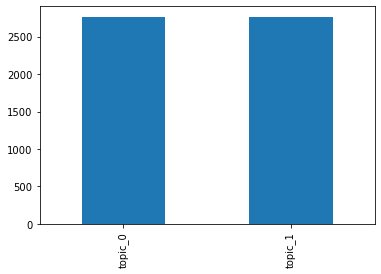

In [32]:
word_topic_matrix_df.count().plot(kind='bar')
plt.savefig('charts/topics', bbox_inches='tight')

In [33]:
word_topic_matrix_df.shape

(2765, 2)

In [34]:
word_topic_matrix_df.info

<bound method DataFrame.info of              topic_0   topic_1
aaron       0.000000  0.002657
abandon     0.000044  0.000903
abck        0.000098  0.000544
abe         0.000000  0.004352
abil        0.000000  0.000524
...              ...       ...
zero        0.000000  0.005445
zoonova     0.000000  0.000602
zu          0.000000  0.012750
zuckerberg  0.000000  0.008111
zum         0.000000  0.050197

[2765 rows x 2 columns]>